## Hypothesis

Our final ensemble (and all L2 models) is not predicting anything under 20. Creating a classifier able to identify samples with a Pawpularity under 20 could improve the final ensemble.

In [3]:
from ml.vision.data import ImageDataModule
from ml.learner import ImageClassifier
from ml.params import load_cfg

In [4]:
import pandas as pd

df = pd.read_csv("../data/train_folds.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold,ignore
0,0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0,0
1,1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2,0
2,2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,3,0
3,3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3,1
4,4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,1,0


In [5]:
train_image_fpaths = [f"../data/train/{i}.jpg" for i in df[(df.kfold!=0)]["Id"]]
train_targets = [[t / 100.] for t in df[(df.kfold!=0)].Pawpularity.tolist()]

In [6]:
val_image_fpaths = [f"../data/train/{i}.jpg" for i in df[df.kfold==0]["Id"]]
val_targets = [[t / 100.] for t in df[df.kfold==0].Pawpularity.tolist()]

In [7]:
train_image_fpaths[:5]

['../data/train/0009c66b9439883ba2750fb825e1d7db.jpg',
 '../data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg',
 '../data/train/0018df346ac9c1d8413cfcc888ca8246.jpg',
 '../data/train/001dc955e10590d3ca4673f034feeef2.jpg',
 '../data/train/001dd4f6fafb890610b1635f967ea081.jpg']

In [8]:
train_targets[:5]

[[0.42], [0.28], [0.15], [0.72], [0.74]]

In [9]:
cfg = load_cfg("../params.yaml", cfg_name="train_two")
cfg.metric = 'auc'
cfg.metric_mode = 'max'
cfg

{'name': 'two', 'seed': 7591, 'n_folds': 5, 'fold': -1, 'metric': 'auc', 'metric_mode': 'max', 'train_data': 'data/train', 'arch': 'swin_large_patch4_window7_224', 'pretrained': True, 'epochs': 6, 'bs': 64, 'auto_batch_size': False, 'accumulate_grad_batches': 1, 'precision': 'bf16', 'use_normalize': True, 'n_tfms': 1, 'magn': 5, 'sz': 224, 'use_mix': 0, 'mix_p': 0.0, 'resize': -1, 'dropout': 0.0, 'wd': 0.0, 'label_smoothing': 0.1, 'loss': 'bce_with_logits', 'opt': 'adamw', 'sched': 'cosine', 'warmup_epochs': 1, 'lr': 5e-05, 'auto_lr': False, 'mom': 0.9}

In [10]:
from timm.data import transforms_factory

train_aug = transforms_factory.create_transform(
    input_size=cfg.sz,
    is_training=True,
    auto_augment=f"rand-n{cfg.n_tfms}-m{cfg.magn}",
)
val_aug = transforms_factory.create_transform(
    input_size=cfg.sz,
    is_training=False,
)

In [11]:
dm = ImageDataModule(
    task="classification",
    batch_size=32,
    # train
    train_image_paths=train_image_fpaths,
    train_targets=train_targets,
    train_augmentations=val_aug,
    # test
    test_image_paths=val_image_fpaths,
    test_augmentations=val_aug,
)
dm.setup()

In [12]:
model = ImageClassifier(
    in_channels=3,
    num_classes=1,
    pretrained=cfg.pretrained,
    cfg=cfg,
)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [13]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names


nodes, _ = get_graph_node_names(model.head)
print(nodes)

['input_1', '0', '1', '2', '3']


In [16]:
model.head

Sequential(
  (0): LazyLinear(in_features=0, out_features=128, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
# feature_extractor = create_feature_extractor(
#     model.head, return_nodes=['2'])

import torch

# input = torch.randn(2, 3, 224, 224)
# x = model.backbone(input)
# out = feature_extractor(x)
# out['2']

In [71]:
ckpt_fpaths = [
    f"../ckpts/model_{cfg.name}_fold{i}.ckpt"
    for i in range(cfg.n_folds)
]
ckpt_fpaths

['../ckpts/model_two_fold0.ckpt',
 '../ckpts/model_two_fold1.ckpt',
 '../ckpts/model_two_fold2.ckpt',
 '../ckpts/model_two_fold3.ckpt',
 '../ckpts/model_two_fold4.ckpt']

In [72]:
# print(f"Generating predictions using model {cfg.name}...")
# for idx, ckpt_fpath in enumerate(ckpt_fpaths[:2]):
ckpt = torch.load(ckpt_fpaths[0])
model.load_state_dict(ckpt["state_dict"])

model.backbone.to('cuda')
model.backbone.eval();

In [73]:
model.head.to('cuda')
model.head.eval()
feature_extractor = create_feature_extractor(
    model.head, return_nodes=['1'])

In [74]:
train_emb = []
tar = []
for batch in dm.train_dataloader():
    out = feature_extractor(model.backbone(batch[0].to('cuda')))['1'].detach().cpu().numpy()
    train_emb.extend(out) 
    tar.extend(batch[1].detach().cpu().numpy())

In [75]:
import numpy as np

train_emb = np.vstack(train_emb)
train_emb.shape

(7872, 128)

In [76]:
tar = np.vstack(tar)
tar.shape

(7872, 1)

In [77]:
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV

In [78]:
reg = LassoCV()
reg.fit(X=train_emb, y=tar.ravel())

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:443: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more d

LassoCV()

In [79]:
test_emb = []
for batch in dm.test_dataloader():
    out = feature_extractor(model.backbone(batch.to('cuda')))['1'].detach().cpu().numpy()
    test_emb.extend(out) 

In [80]:
y_hat = np.clip(reg.predict(X=test_emb), a_min=0, a_max=1)

In [81]:
y_hat.min(), y_hat.mean(), y_hat.max(), 

(0.11538547, 0.3834828, 1.0)

In [82]:
from sklearn.metrics import mean_squared_error

mean_squared_error(val_targets, y_hat, squared=False)

0.1724056672829159

In [83]:
17.24

17.24

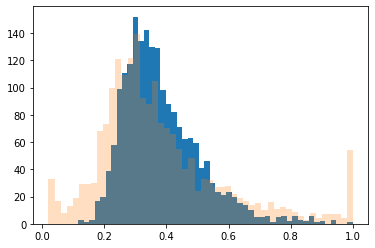

In [84]:
import matplotlib.pyplot as plt

plt.hist(y_hat, bins=50);
plt.hist(np.array(val_targets), bins=50, alpha=.25);

## nn.Identity()

In [85]:
dm = ImageDataModule(
    task="classification",
    batch_size=32,
    # test
    test_image_paths=train_image_fpaths,
    test_augmentations=val_aug,
)
dm.setup()

ckpt = torch.load(ckpt_fpaths[0])
model = ImageClassifier(
    in_channels=3,
    num_classes=1,
    pretrained=cfg.pretrained,
    cfg=cfg,
)
model.load_state_dict(ckpt["state_dict"])
from torch import nn
model.head = nn.Identity()

import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1)
preds = trainer.predict(model, dm.test_dataloader())

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [86]:
train_emb = np.vstack(preds)
reg = SVR()
reg.fit(X=train_emb, y=train_targets)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR()

In [87]:
dm = ImageDataModule(
    task="classification",
    batch_size=32,
    # test
    test_image_paths=val_image_fpaths,
    test_augmentations=val_aug,
)
dm.setup()

ckpt = torch.load(ckpt_fpaths[0])
model = ImageClassifier(
    in_channels=3,
    num_classes=1,
    pretrained=cfg.pretrained,
    cfg=cfg,
)
model.load_state_dict(ckpt["state_dict"])
from torch import nn
model.head = nn.Identity()

import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1)
preds = trainer.predict(model, dm.test_dataloader())

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [88]:
test_emb = np.vstack(preds)
y_hat = np.clip(reg.predict(X=test_emb), a_min=0, a_max=1)

In [89]:
y_hat.min(), y_hat.mean(), y_hat.max(), 

(0.07818510943675377, 0.39200319615122403, 1.0)

In [90]:
from sklearn.metrics import mean_squared_error

mean_squared_error(val_targets, y_hat, squared=False)

0.17914925780404223

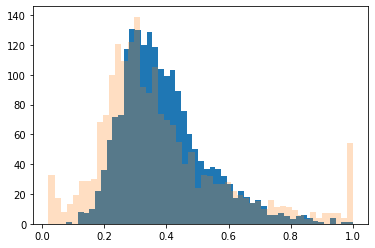

In [91]:
import matplotlib.pyplot as plt

plt.hist(y_hat, bins=50);
plt.hist(np.array(val_targets), bins=50, alpha=.25);